# Create signal for latency tests

Because the trial recordings from the Steinmetz data are only 2.5 sec long each, we need to create a longer "test signal" for testing our real-time filtering prototypes. We do this by concatenating the spike trains across trials.

Assuming the raw Steinmetz data is downloaded (see  [01_examine_raw_data.ipynb](./01_examine_raw_data.ipynb)), running the code in this notebook will create the test signal and store it in `<project root>/data/processed`.

In addition to the "standard" test signal file, this notebook also creates a file containing the same data, but with the matrix dimensions flipped, so that it can be read by the C implementation, which needs to read data in row-major order.

## Imports

In [1]:
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt

## Create test signal

In [2]:
# Directory where raw data files are stored
RAW_DATA_DIR = '../data/raw'

# Filenames to load data from (in order!)
RAW_DATA_FNAMES = ['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']

# Session to use for test signal
SESSION_NUM = 11

# Output directory
PROCESSED_DATA_DIR = '../data/processed'

# File name for Python, Julia and Rust implementations
OUT_FNAME = 'test_spks.h5'

# File name for C implementation
OUT_FNAME_C = 'test_spks_c.h5'

# Load raw Steinmetz data from files
print(f'Loading Steinmetz data from {RAW_DATA_DIR}...')
input_fpaths = [os.path.join(RAW_DATA_DIR, f) for f in RAW_DATA_FNAMES]
all_sessions = np.array([])
for f in input_fpaths:
    all_sessions = np.hstack((all_sessions, np.load(f, allow_pickle=True)['dat']))
print('Done.')

# Unpack session data
data = all_sessions[SESSION_NUM]
bin_size_sec = data['bin_size']
spks = data['spks']
n_neurons = spks.shape[0]

# Create test signal by concatenating data from all trials
spks_all_trials = spks.reshape(n_neurons, -1)

# Save test signal to HDF5 file
test_signal_fpath = os.path.join(PROCESSED_DATA_DIR, OUT_FNAME)
print(f'Writing to {test_signal_fpath}...')
with h5py.File(test_signal_fpath, 'w') as f:
    dset = f.create_dataset('spks', data=spks_all_trials)
    dset.attrs['session_num'] = SESSION_NUM
    dset.attrs['bin_size_sec'] = bin_size_sec
print('Done.')

# Create test signal for C implementation by flipping dimensions
spks_all_trials_c = spks_all_trials.T

# Save C test signal to HDF5 file
test_signal_c_fpath = os.path.join(PROCESSED_DATA_DIR, OUT_FNAME_C)
print(f'Writing to {test_signal_c_fpath}...')
with h5py.File(test_signal_c_fpath, 'w') as f:
    dset = f.create_dataset('spks', data=spks_all_trials_c)
    dset.attrs['session_num'] = SESSION_NUM
    dset.attrs['bin_size_sec'] = bin_size_sec
print('Done.')

Loading Steinmetz data from ../data/raw...
Done.
Writing to ../data/processed/test_spks.h5...
Done.
Writing to ../data/processed/test_spks_c.h5...
Done.


## Load test signal from file

In [3]:
with h5py.File(test_signal_fpath, 'r') as f:
    spks = f['spks'][:]
    session_num = f['spks'].attrs['session_num']
    bin_size_sec = f['spks'].attrs['bin_size_sec']
    n_neurons = spks.shape[0]
    n_pts = spks.shape[1]
    
print(f'Session num: {session_num}')
print(f'Num. neurons: {n_neurons}')
print(f'Num. points: {n_pts}')
print(f'Bin size (sec): {bin_size_sec}')

Session num: 11
Num. neurons: 698
Num. points: 85000
Bin size (sec): 0.01


## Plot spike counts for selected dimensions, time range

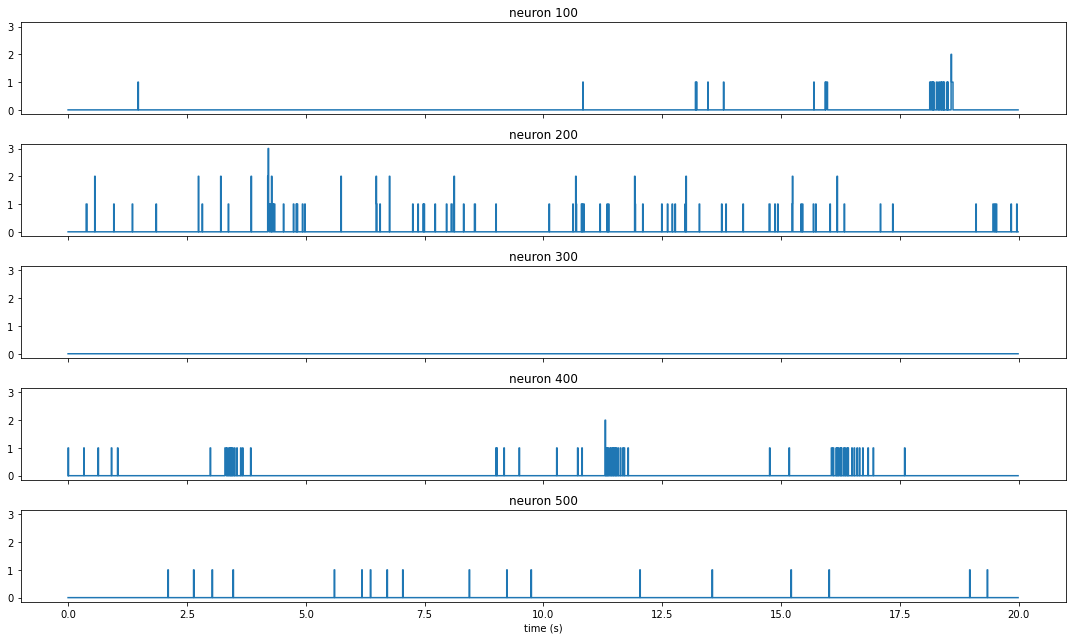

In [4]:
# Neurons to plot
NEURONS_PLT = [100, 200, 300, 400, 500]

# Index range to plot
IDX_START = 0
IDX_END = 2000

t_vals = bin_size_sec * np.arange(IDX_START, IDX_END)

fig, ax = plt.subplots(len(NEURONS_PLT), 1, figsize=(15, 9), sharex=True, sharey=True)

for i, n in enumerate(NEURONS_PLT):
    ax[i].set_title(f'neuron {n}')
    ax[i].plot(t_vals, spks[n, IDX_START:IDX_END], drawstyle='steps-pre')

ax[-1].set(xlabel='time (s)')
    
plt.tight_layout()